In [1]:
import torch, argparse, gzip, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl
from tqdm.notebook import tqdm
from pytorch_lightning.loggers import MLFlowLogger
from mlflow.tracking.artifact_utils import get_artifact_uri, _get_root_uri_and_artifact_path
from data_loader import load_train_data, load_test_data
from models import ConvNet
from mlflow_helper import init_mlf_logger
# from mlflow_helper import create_artifact_dir

# warnings.filterwarnings('ignore')

In [2]:
TRAIN_SAMPLES = 10000
TRAIN_ROT = True
TEST_ROT = True

# MAX_EPOCHS = 20
MAX_EPOCHS = 3

In [3]:
if TRAIN_ROT:
    TRAIN_PATH = "s2_mnist_train_dwr_" + str(TRAIN_SAMPLES) + ".gz"
else:
    raise NotImplementedError('A non-rotated training set does not exist yet.')
    
if TEST_ROT:
    TEST_PATH = "s2_mnist_cs1.gz"
else:
    raise NotImplementedError('A non-rotated test set does not exist yet.')

if torch.cuda.is_available():
    print('GPU available: ' + torch.cuda.get_device_name())
else:
    raise RuntimeError('No GPU found.')

GPU available: NVIDIA GeForce RTX 2070 SUPER


In [4]:
train_data, test_data = load_train_data(TRAIN_PATH), load_test_data(TEST_PATH)

print("Total training examples: {}".format(len(train_data)))
print("Total test examples: {}".format(len(test_data)))

hparams = argparse.Namespace()

hparams.name = 'test_model'
hparams.train_batch_size = 32
hparams.test_batch_size = 32
hparams.num_workers = 0
hparams.lr = 1e-3
hparams.weight_decay = 0.

hparams.channels = [13, 15, 22, 31, 141]
hparams.kernels = [5, 3, 9, 7, 3]
hparams.strides = [1, 1, 1, 1, 2]
hparams.activation_fn = 'ReLU'
hparams.batch_norm = True
hparams.nodes = [64, 32]

Total training examples: 10000
Total test examples: 10000


In [5]:
tracking_uri='sqlite:///mlruns/database.db'

"""mlf_logger = MLFlowLogger(experiment_name='test_log', tracking_uri=tracking_uri)

artifact_path = get_artifact_uri(run_id=mlf_logger.run_id, tracking_uri=tracking_uri)

create_artifact_dir(artifact_path, mlf_logger)"""

tag_dict = {"mlflow.runName": round(time.time()),
           "mlflow.user": "dschuh"}

mlf_logger, artifact_path = init_mlf_logger(experiment_name='test_log', tracking_uri=tracking_uri, tags=tag_dict, verbose=True)

# mlf_logger.experiment.set_tag(run_id=mlf_logger.run_id, key="mlflow.runName", value=round(time.time()))
# mlf_logger.experiment.set_tag(run_id=mlf_logger.run_id, key="mlflow.user", value="dschuh")



run ID directory created
artifact directory created


In [6]:
model = ConvNet(hparams, train_data, test_data)
mlf_logger.experiment.set_tag(run_id=mlf_logger.run_id, key="model", value=model.__class__.__name__)

print(f"Number of trainable / total parameters: {model.count_trainable_parameters(), model.count_parameters()}")

monitor = 'val_acc'
mode = 'max'
early_stopping = pl.callbacks.EarlyStopping(monitor=monitor, min_delta=0., patience=10, mode=mode)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(filepath=artifact_path, monitor=monitor, mode=mode)

"""mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='es_min_delta', value=early_stopping.min_delta)
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='es_mode', value=early_stopping.mode)
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='es_monitor', value=early_stopping.monitor)
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='es_patience', value=early_stopping.patience)
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='max_epochs', value=MAX_EPOCHS)
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='train_samples', value=len(train_data))
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='train_rot', value=TRAIN_ROT)
mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='test_rot', value=TEST_ROT)"""

log_dict = {'es_min_delta': early_stopping.min_delta,
           'es_mode': early_stopping.mode,
           'es_monitor': early_stopping.monitor,
           'es_patience': early_stopping.patience,
           'max_epochs': MAX_EPOCHS,
           'train_samples': len(train_data),
           'train_rot': TRAIN_ROT,
           'test_rot': TEST_ROT}

mlf_logger.log_hyperparams(log_dict)

trainer = pl.Trainer(gpus=1, max_epochs=MAX_EPOCHS, logger=mlf_logger, early_stop_callback=early_stopping, checkpoint_callback=checkpoint)

trainer.fit(model)

mlf_logger.experiment.log_param(run_id=mlf_logger.run_id, key='es_stopped_epoch', value=early_stopping.stopped_epoch)

best_model = torch.load(checkpoint.best_model_path)
model.load_state_dict(best_model['state_dict'])
model.eval()
test_results = trainer.test(model)

Number of trainable / total parameters: (113761, 113761)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_function | CrossEntropyLoss | 0     
1 | conv          | Sequential       | 101 K 
2 | dense         | Sequential       | 11 K  
/media/data/schuh/conda_envs/envs/s2cnn_j/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/media/data/schuh/conda_envs/envs/s2cnn_j/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/media/data/schuh/conda_envs/envs/s2cnn_j/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': tensor(0.5268), 'test_loss': 1.3439254760742188}
--------------------------------------------------------------------------------


{'test_loss': 1.3439254760742188, 'test_acc': 0.5267999768257141}

In [ ]:
filename = 'test_results.pickle'

if os.path.isfile(os.path.join(artifact_path, filename)):
    filename = str(time.time()) + filename
    print('File already existed, timestamp was prepended to filename.')
    
with open(os.path.join(artifact_path, filename), 'wb') as file:
    pickle.dump(test_results, file)

In [7]:
print(artifact_path)
print(_get_root_uri_and_artifact_path(artifact_path))
print(mlf_logger.experiment.tracking_uri)
print(mlf_logger.name)
print(mlf_logger.run_id)
print(mlf_logger.experiment.list_experiments())

./mlruns/1/edf4e4794c7741d5b54f1c1634965882/artifacts
('./mlruns/1/edf4e4794c7741d5b54f1c1634965882', 'artifacts')
sqlite:///mlruns/database.db
1
edf4e4794c7741d5b54f1c1634965882
[<Experiment: artifact_location='./mlruns/1', creation_time=1667566610574, experiment_id='1', last_update_time=1667566610574, lifecycle_stage='active', name='test_log', tags={}>]


/media/data/schuh/conda_envs/envs/s2cnn_j/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  


In [8]:
import matplotlib.pyplot as plt

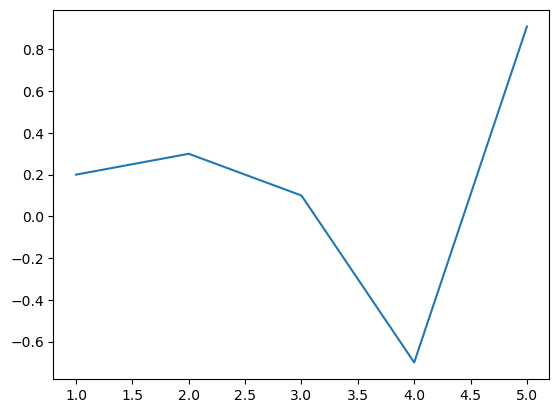

In [9]:
plt.plot([1,2,3,4,5], [0.2, 0.3, 0.1, -0.7, 0.91])
plt.savefig(os.path.join(artifact_path, 'test_image.png'))

In [10]:
# mlf_logger.experiment.log_artifact()

In [11]:
print(mlf_logger.experiment_id)
print(mlf_logger.name)

1
1


In [12]:
print(early_stopping.stopped_epoch) # gives 0 if it did not early stop
print(early_stopping.wait_count)

5
1
